In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')


In [3]:
#making a new feature consisting of titles of passesngers
data = [train_data,test_data]
titles = {"Mr":1,"Miss":2,"Mrs":3,"Master":4,"Rare":5}
for dataset in data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.',expand = False)
    dataset['Title'] = dataset['Title'].replace(['Don','Rev','Dr','Major','Lady','Sir','Col',
                                                'Capt','Countess','Dona','Jonkheer'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(0)



In [4]:
#mapping Sex into integer values
sex_values = {'female':1,'male':0}
data = [train_data,test_data]
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(sex_values)

In [5]:
#making a new feature based on 'Cabin' called Deck
import re
deck = {"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7,"U":8}
data = [train_data,test_data]
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna('U0')
    dataset['Deck'] = dataset['Cabin'].map(lambda x :re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck']  = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

    
train_data = train_data.drop(['Cabin'],axis = 1)
test_data = test_data.drop(['Cabin'],axis = 1)
    

In [6]:
#filling missing value in embarked
common_value = 'S'
ports = {'S':0,'C':1,'Q':2}
data = [train_data,test_data]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [7]:
#filling missing values in age with mean value and convert float to int in train_data
mean_value = train_data['Age'].mean()
data = [train_data,test_data]
for dataset in data:
    
    dataset['Age'] = dataset['Age'].fillna(mean_value)

    dataset['Age'] = dataset['Age'].astype(int)

    #cataegorising Age into different Age Groups
    category = pd.cut(dataset.Age,bins = [-1,11,18,22,27,33,40,66,81],labels = [0,1,2,3,4,5,6,7])
    dataset.insert(6,'Age_Group',category)

for dataset in data:
    dataset['Age_Group'] = dataset['Age_Group'].astype(int)





In [8]:
#combining SibSp and Parch into a new column called relatives
data = [train_data,test_data]
for dataset in data:
    values = dataset.SibSp + dataset.Parch
    dataset.insert(6,'Relatives',values)

In [9]:
#dividing Fare into Groups
mean_value_test_Fare = test_data['Fare'].mean()
test_data['Fare'] = test_data['Fare'].fillna(mean_value_test_Fare)
data = [train_data,test_data]
train_data['Fare'] = train_data['Fare'].astype(int)
test_data['Fare'] = test_data['Fare'].astype(int)
for dataset in data:
    dataset.loc[dataset['Fare'] <=7.9,'Fare'] = 0
    dataset.loc[(dataset['Fare'] >7.9) & (dataset['Fare']<=14.4),'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.4) &(dataset['Fare']<= 31),'Fare'] = 2
    dataset.loc[(dataset['Fare']>31) & (dataset['Fare']<=99) , 'Fare'] = 3
    dataset.loc[(dataset['Fare']>99) & (dataset['Fare']<=250) , 'Fare'] = 4
    dataset.loc[dataset['Fare']>250 ,'Fare'] = 5
    
    




    

In [10]:
#combining age group,deck and sex
data = [train_data,test_data]
for dataset in data:
    dataset['custom'] = dataset['Age_Group']*dataset['Sex'] * dataset['Deck']

In [11]:
#making a new category combining Age_Group and Pclass
data = [train_data,test_data]
for dataset in data:
    dataset['Age_Pclass'] = dataset['Age_Group'] *dataset['Pclass']

In [12]:
#making a new category combining Age_group and Sex
data = [train_data,test_data]
for dataset in data:
    dataset['AgeSex'] = dataset['Age_Group'] * dataset['Sex']

In [13]:
#making a new features fare per person
data = [train_data,test_data]
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['Relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [14]:
#forming training data and testing data set
features = ['custom','AgeSex','Title','Pclass','Sex','Relatives','Age_Group','SibSp','Deck','Fare','Fare_Per_Person','Age_Pclass','Embarked']
y = train_data['Survived']
X = train_data[features]
X_test = test_data[features]



In [16]:
#performing K-Fold Cross Validation and finding cross validation score using 10 folds
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(criterion = "gini",
                              min_samples_leaf = 1,
                              min_samples_split = 10,
                              n_estimators = 1000,
                              max_depth = 100,
                              oob_score = 'auto',
                              n_jobs = -1,
                              random_state = 1)

scores = cross_val_score(model,X,y,cv =10,scoring = 'accuracy')
print("Scores:",scores)
print("Mean:",scores.mean())
print("Standard Deviation:",scores.std())




Scores: [0.82222222 0.85393258 0.76404494 0.87640449 0.88764045 0.84269663
 0.85393258 0.7752809  0.86516854 0.84269663]
Mean: 0.8384019975031209
Standard Deviation: 0.03857379720121987


In [19]:
#plotting the relative importance of each feature in the dataset
model.fit(X,y)
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending = False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.161
Sex,0.138
custom,0.102
AgeSex,0.096
Pclass,0.082
Age_Pclass,0.074
Relatives,0.067
Deck,0.063
Fare,0.054


In [20]:
#computing F-score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(model,X,y,cv = 3)
f1_score(y,predictions)


0.7727975270479135

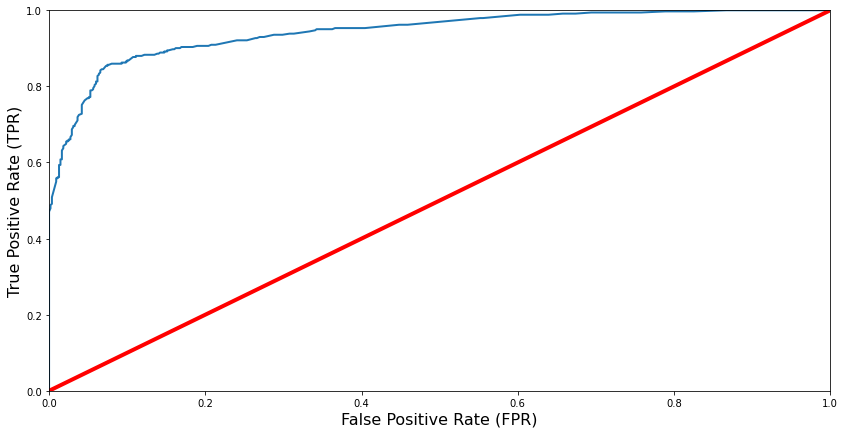

In [23]:
#plotting ROC AUC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
y_scores = model.predict_proba(X)#getting probabilities of predictions on X
y_scores = y_scores[:,1]
false_positive,true_positive,thresholds = roc_curve(y,y_scores)
def plot_roc_curve(false_positive, true_positive, label=None):
    plt.plot(false_positive, true_positive, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive, true_positive)
plt.show()

In [26]:
#computing roc auc score
from sklearn.metrics import roc_auc_score

raScore = roc_auc_score(y,y_scores)
print("ROC_AUC_SCORE:",raScore)

ROC_AUC_SCORE: 0.9430010971569787


In [28]:
#generating results for testing dataset
model.fit(X,y)
predictions = model.predict(X_test)
predictions

#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('my_submission_LOL.csv', index=False)
#print("Your submission was successfully saved!")


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,